In [19]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import tetrion.plots as plots
import tetrion.db
import tetrion.commands as cmd
import tetrion.options
import tetrion.clientcore
import seaborn as sns
from collections import defaultdict
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
%matplotlib inline 
symbol = pd.read_csv('/local/dist/tetrion/conf/conf/symbol.table', skiprows= 1, header = 2,  delim_whitespace=True)
pd.set_option('display.max_rows', 100)
import datetime as dt

In [20]:
df = pd.read_pickle('../data/vix_1min_2025.pkl')
df = df.sort_values("time").reset_index(drop=True)
df = df[df['time'].dt.month < 9].reset_index(drop=True)
df3 = pd.read_pickle('../data/TXF_H1.pkl')
df4 = pd.read_pickle('../data/TXF_H2.pkl')

# Merge H1 and H2, then filter before September and sort by time/index
df2 = pd.concat([df3, df4]).sort_index()
df2 = df2[df2.index.month < 9]

In [21]:
df2

,mkt_mid,contract
time,,
2025-01-02 09:00:00,22936.0,FUT_TAIFEX_TXF:202501
2025-01-02 09:01:00,22949.0,FUT_TAIFEX_TXF:202501
2025-01-02 09:02:00,22957.0,FUT_TAIFEX_TXF:202501
2025-01-02 09:03:00,22948.0,FUT_TAIFEX_TXF:202501
2025-01-02 09:04:00,22950.5,FUT_TAIFEX_TXF:202501
...,...,...
2025-08-29 13:40:00,24270.0,FUT_TAIFEX_TXF:202509
2025-08-29 13:41:00,24268.0,FUT_TAIFEX_TXF:202509
2025-08-29 13:42:00,24270.0,FUT_TAIFEX_TXF:202509


In [ ]:
import pandas as pd
import numpy as np


def gamma_hedge_backtest_new_pnl(
    df,
    price_col="price",
    gamma=10.0,
    delta_threshold=1000.0,
    contract_multiplier=200.0,
    fee_per_contract=10.0,
    s_ref=None,
 ):
    """
    Gamma hedge backtest with:
      - Integer futures hedging (rounded contracts)
      - Daily reset of ref price and futures position
      - Gamma PnL: 0.5 * gamma * (S_t - day_open)^2  (no multiplier)
      - Hedge PnL: cumulative futures PnL minus transaction costs
      - Futures transaction cost: fee_per_contract per contract change
      - Tracks number of hedge trades (futures adjustments) and trade prices
    Returns: dict with total_pnl, gamma_pnl, hedge_pnl, equity_curve, details, hedge_trades
    """
    df = df.copy()

    # Ensure time column exists and avoid index/column name clash
    if "time" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df["time"] = df.index
        else:
            raise ValueError("DataFrame must have a 'time' column or a DatetimeIndex.")
    if df.index.name == "time":
        df.index.name = "time_index"

    df = df.sort_values("time")

    groups = df.groupby(df["time"].dt.date)

    total_gamma_pnl = 0.0
    cum_hedge_pnl = 0.0
    hedge_trades = 0  # count futures adjustments

    equity_list = []
    equity_index = []
    records = []

    for _, group in groups:
        group = group.sort_values("time")
        prices = group[price_col].values
        times = group["time"].values
        if len(prices) < 1:
            continue

        day_open = float(prices[0])
        fut_pos = 0.0
        last_price = day_open

        for i in range(len(prices)):
            t = times[i]
            price_now = float(prices[i])
            dS = price_now - last_price

            # Hedge PnL accrues on existing futures position
            cum_hedge_pnl += fut_pos * dS * contract_multiplier

            # Gamma PnL relative to today's open (no multiplier)
            day_gamma_pnl = 0.5 * gamma * (price_now - day_open) ** 2

            # Delta calculations
            opt_delta = gamma * (price_now - day_open)
            fut_delta = fut_pos * contract_multiplier
            total_delta = opt_delta + fut_delta

            trade_size = 0
            trade_price = np.nan
            # Integer-contract hedge when threshold hit
            if abs(total_delta) >= delta_threshold:
                ideal_fut_pos = -opt_delta / contract_multiplier
                target_fut_pos = round(ideal_fut_pos)
                if target_fut_pos != fut_pos:
                    trade_size = abs(target_fut_pos - fut_pos)
                    trade_price = price_now
                    fut_pos = target_fut_pos
                    fut_delta = fut_pos * contract_multiplier
                    total_delta = opt_delta + fut_delta
                    hedge_trades += trade_size  # count contracts traded
                    # Subtract transaction cost for contract changes
                    cum_hedge_pnl -= trade_size * fee_per_contract

            # Current totals
            gamma_total = total_gamma_pnl + day_gamma_pnl
            total_equity = gamma_total + cum_hedge_pnl

            equity_list.append(total_equity)
            equity_index.append(t)

            records.append({
                "time": t,
                "price": price_now,
                "day_s_ref": day_open,
                "opt_delta": opt_delta,
                "fut_pos": fut_pos,
                "total_delta": total_delta,
                "day_gamma_pnl": day_gamma_pnl,
                "gamma_pnl": gamma_total,
                "hedge_pnl": cum_hedge_pnl,
                "equity": total_equity,
                "trade_size": trade_size,
                "trade_price": trade_price,
            })

            last_price = price_now

        # Lock in end-of-day gamma PnL
        final_day_gamma = 0.5 * gamma * (last_price - day_open) ** 2
        total_gamma_pnl += final_day_gamma

    equity_curve = pd.Series(equity_list, index=equity_index)
    details_df = pd.DataFrame(records).set_index("time")

    result = {
        "total_pnl": float(total_gamma_pnl + cum_hedge_pnl),
        "gamma_pnl": float(total_gamma_pnl),
        "hedge_pnl": float(cum_hedge_pnl),
        "hedge_trades": int(hedge_trades),
        "equity_curve": equity_curve,
        "details": details_df,
    }
    return result


In [33]:
def run_gamma_hedge_new_pnl_thresholds(
    df,
    price_col="price",
    gamma=10.0,
    delta_thresholds=(0.0, 200,400,600, 800,1000.0,1200,1400,1600, 2000.0),
    contract_multiplier=200.0,
    s_ref=None,
 ):
    """
    Run the new gamma-hedge PnL backtest for multiple delta thresholds.
    Returns a summary DataFrame and a dict of full results.
    """
    summary = []
    all_results = {}

    for th in delta_thresholds:
        res = gamma_hedge_backtest_new_pnl(
            df=df,
            price_col=price_col,
            gamma=gamma,
            delta_threshold=th,
            contract_multiplier=contract_multiplier,
            s_ref=s_ref,
        )
        all_results[th] = res
        summary.append({
            "delta_threshold": th,
            "total_pnl": res["total_pnl"],
            "gamma_pnl": res["gamma_pnl"],
            "hedge_pnl": res["hedge_pnl"],
        })

    summary_df = pd.DataFrame(summary).set_index("delta_threshold").sort_index()
    return summary_df, all_results


In [34]:
# Run backtest and pick a working set for plotting/diagnostics
price_col = "mkt_mid" if "mkt_mid" in df2.columns else ("price" if "price" in df2.columns else None)
if price_col is None:
    raise ValueError("Price column not found in df2 (expected 'mkt_mid' or 'price').")
thresholds = [200.0, 400.0, 600.0,800.0, 1000.0, 1200.0, 1400.0, 1600.0, 2000.0]
summary_df, all_results = run_gamma_hedge_new_pnl_thresholds(
    df=df2,
    price_col=price_col,
    gamma=10.0,
    delta_thresholds=thresholds,
    contract_multiplier=200.0,
 )

# Choose a default threshold to visualize
default_th = 600.0
details = all_results[default_th]["details"]
res_selected = all_results[default_th]
print(summary_df)

                  total_pnl   gamma_pnl  hedge_pnl
delta_threshold                                   
200.0            19226435.0  27999705.0 -8773270.0
400.0            19339575.0  27999705.0 -8660130.0
600.0            19321075.0  27999705.0 -8678630.0
800.0            19672585.0  27999705.0 -8327120.0
1000.0           19870105.0  27999705.0 -8129600.0
1200.0           21065715.0  27999705.0 -6933990.0
1400.0           23007425.0  27999705.0 -4992280.0
1600.0           22136805.0  27999705.0 -5862900.0
2000.0           21598525.0  27999705.0 -6401180.0


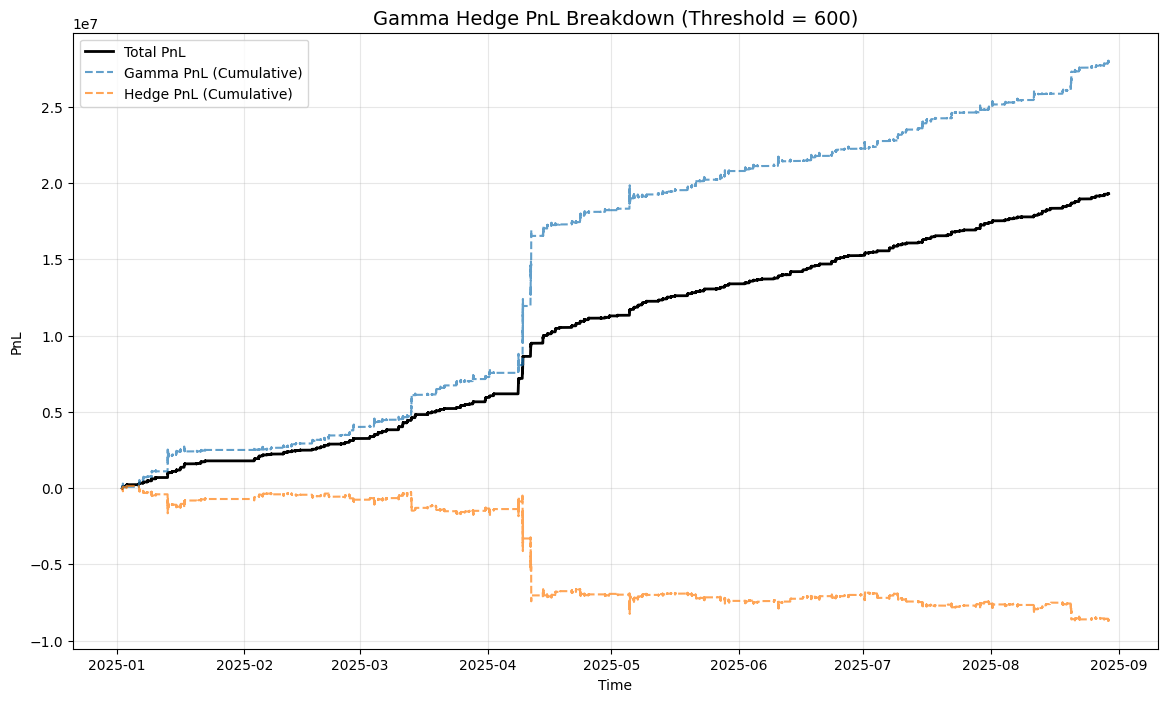

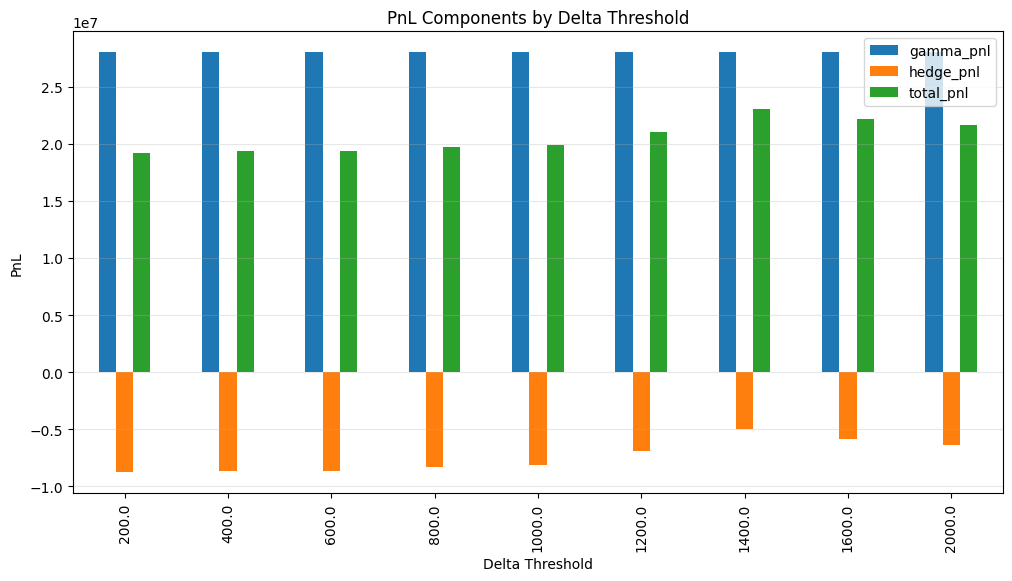

In [35]:
import matplotlib.pyplot as plt

# 1. Plot Time Series for Threshold = 600
plt.figure(figsize=(14, 8))

plt.plot(details.index, details['equity'], label='Total PnL', linewidth=2, color='black')
plt.plot(details.index, details['gamma_pnl'], label='Gamma PnL (Cumulative)', linestyle='--', alpha=0.7)
plt.plot(details.index, details['hedge_pnl'], label='Hedge PnL (Cumulative)', linestyle='--', alpha=0.7)

plt.title('Gamma Hedge PnL Breakdown (Threshold = 600)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('PnL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Plot Summary Comparison
plt.figure(figsize=(12, 6))
summary_df[['gamma_pnl', 'hedge_pnl', 'total_pnl']].plot(kind='bar', ax=plt.gca())
plt.title('PnL Components by Delta Threshold')
plt.ylabel('PnL')
plt.xlabel('Delta Threshold')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

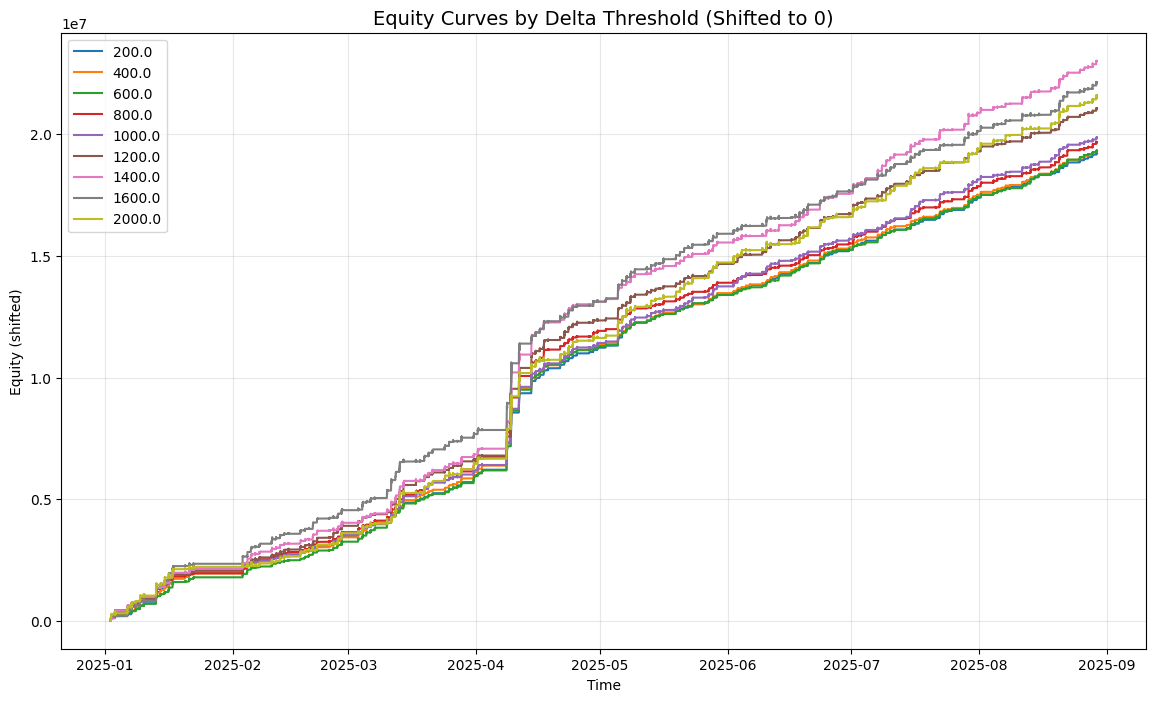

Per-step PnL smoothness (std):
           step_pnl_std  step_pnl_mean
threshold                             
200.0       1728.475958     422.726243
400.0       2205.496289     425.213821
600.0       2913.570049     424.807067
800.0       3573.817394     432.535618
1000.0      4129.347848     436.878435
1200.0      4942.561856     463.165978
1400.0      5652.710477     505.857812
1600.0      6269.829524     486.715734
2000.0      7550.608823     474.880722


In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot all thresholds equity curves (shifted to start at 0) to compare smoothness
plt.figure(figsize=(14, 8))

smooth_stats = []
for th, res in all_results.items():
    curve = res["equity_curve"].copy()
    # shift to start at 0 for visual comparability
    curve = curve - curve.iloc[0]
    plt.plot(curve.index, curve.values, label=f"{th}")

    # simple smoothness metrics: per-step PnL std and mean
    step_pnl = curve.diff().dropna()
    smooth_stats.append({
        "threshold": th,
        "step_pnl_mean": step_pnl.mean(),
        "step_pnl_std": step_pnl.std(),
    })

plt.title("Equity Curves by Delta Threshold (Shifted to 0)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Equity (shifted)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display smoothness table (lower std = smoother)
smooth_df = pd.DataFrame(smooth_stats).set_index("threshold").sort_index()
print("Per-step PnL smoothness (std):")
print(smooth_df[["step_pnl_std", "step_pnl_mean"]])

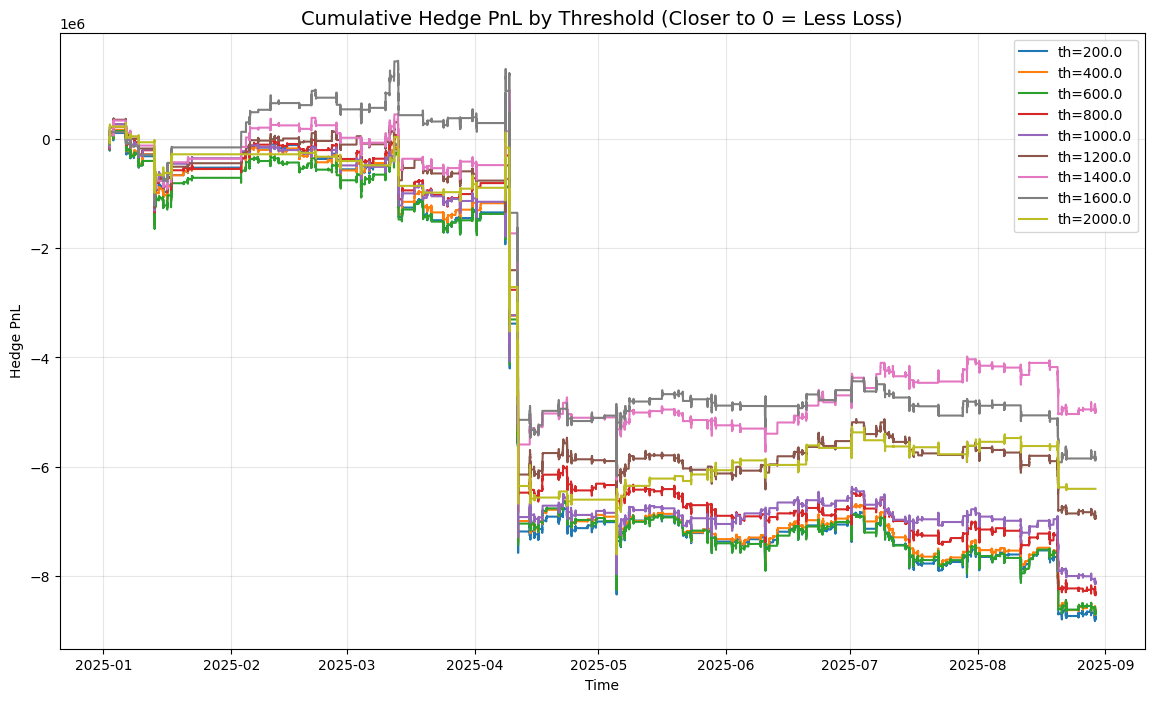

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Focus on Hedge PnL: Compare which threshold loses the least amount of money on hedging
# This isolates the "cost" side of the strategy.

if 'all_results' in locals():
    plt.figure(figsize=(14, 8))
    hedge_stats = []

    for th, res in all_results.items():
        # Cumulative Hedge PnL curve
        # details['hedge_pnl'] is the cumulative series
        h_curve = res["details"]["hedge_pnl"]
        
        plt.plot(h_curve.index, h_curve.values, label=f"th={th}")
        
        hedge_stats.append({
            "threshold": th,
            "total_hedge_pnl": res["hedge_pnl"],
            "hedge_trades": res["hedge_trades"],
            "cost_per_trade": res["hedge_pnl"] / res["hedge_trades"] if res["hedge_trades"] > 0 else 0.0
        })

    plt.title("Cumulative Hedge PnL by Threshold (Closer to 0 = Less Loss)", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Hedge PnL")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Table sorted by least loss (highest value, since negative)
    hedge_df = pd.DataFrame(hedge_stats).set_index("threshold")

else:
    print("all_results not found. Run the backtest first.")

In [47]:
import pandas as pd

# Calculate Hedge Statistics: Avg PnL per Trade and Std Dev
hedge_stats_detailed = []

if 'all_results' in locals():
    for th, res in all_results.items():
        details = res["details"]
        
        # Count number of adjustments (trades)
        # Assuming trade_size > 0 indicates a trade occurred
        n_trades = (details["trade_size"] > 0).sum()
        
        # Total Hedge PnL
        total_hedge_pnl = res["hedge_pnl"]
        
        # Average PnL per Trade
        avg_pnl_per_trade = total_hedge_pnl / n_trades if n_trades > 0 else 0.0
        
        # Standard Deviation of Hedge PnL (Per Trade Interval)
        # We look at the PnL accumulated between consecutive trades to capture "per trade" volatility
        trade_events = details[details["trade_size"] > 0]
        if len(trade_events) > 1:
            # PnL change between trade i and trade i+1
            per_trade_pnl = trade_events["hedge_pnl"].diff().dropna()
            std_pnl_per_trade = per_trade_pnl.std()
        else:
            std_pnl_per_trade = 0.0
        
        hedge_stats_detailed.append({
            "threshold": th,
            "total_hedge_pnl": total_hedge_pnl,
            "n_trades": n_trades,
            "avg_pnl_per_trade": avg_pnl_per_trade,
            "std_pnl_per_trade": std_pnl_per_trade
        })

    hedge_detailed_df = pd.DataFrame(hedge_stats_detailed).set_index("threshold")
    print("Hedge Statistics (Global - Ignoring VIX):")
    print(hedge_detailed_df)
else:
    print("all_results not found. Please run the backtest first.")

Hedge Statistics (Global - Ignoring VIX):
           total_hedge_pnl  n_trades  avg_pnl_per_trade  std_pnl_per_trade
threshold                                                                 
200.0           -8773270.0      4735       -1852.855333       65874.394058
400.0           -8660130.0      1604       -5399.083541      107113.177839
600.0           -8678630.0       785      -11055.579618      157312.617647
800.0           -8327120.0       470      -17717.276596      201927.263747
1000.0          -8129600.0       314      -25890.445860      237388.034929
1200.0          -6933990.0       226      -30681.371681      307758.549910
1400.0          -4992280.0       179      -27889.832402      328907.000864
1600.0          -5862900.0       133      -44081.954887      392757.562332
2000.0          -6401180.0        76      -84226.052632      438767.580802


In [28]:
df

,time,vix_like
0,2025-01-02 08:45:00,18.475369
1,2025-01-02 08:46:00,18.423384
2,2025-01-02 08:47:00,18.465699
3,2025-01-02 08:48:00,18.465165
4,2025-01-02 08:49:00,18.559432
...,...,...
47278,2025-08-29 13:41:00,19.782323
47279,2025-08-29 13:42:00,19.764401
47280,2025-08-29 13:43:00,19.753954
47281,2025-08-29 13:44:00,19.759458


In [39]:
import numpy as np
import pandas as pd

# Detect VIX column
_vix_candidates = ["vix_like", "vix", "VIX", "vix_close", "close_vix"]
vix_col = None
for c in _vix_candidates:
    if c in df.columns:
        vix_col = c
        break
if vix_col is None:
    raise ValueError("VIX column not found in df; expected one of: %s" % _vix_candidates)

# Prepare price DataFrame with time column
price_df = df2.reset_index()
if "time" not in price_df.columns:
    if "index" in price_df.columns:
        price_df = price_df.rename(columns={"index": "time"})
    elif isinstance(df2.index, pd.DatetimeIndex):
        price_df["time"] = df2.index
    else:
        raise ValueError("df2 must have a datetime index or a 'time' column")

price_df["time"] = pd.to_datetime(price_df["time"])
vix_df = df[["time", vix_col]].copy()
vix_df["time"] = pd.to_datetime(vix_df["time"])

price_df = price_df.sort_values("time")
vix_df = vix_df.sort_values("time")

# Merge VIX onto price with nearest timestamp (2-minute tolerance)
merged = pd.merge_asof(price_df, vix_df, on="time", direction="nearest", tolerance=pd.Timedelta("2min"))
merged = merged.dropna(subset=[vix_col])

# Define VIX buckets
buckets = [
    (15, 20),
    (20, 25),
    (25, 30),
    (30, np.inf),
]
thresholds = [200.0, 400.0, 600.0, 1000.0]

bucket_summaries = []
bucket_results = {}

for low, high in buckets:
    if np.isfinite(high):
        mask = (merged[vix_col] >= low) & (merged[vix_col] < high)
    else:
        mask = merged[vix_col] >= low

    sub = merged.loc[mask].copy()
    if sub.empty:
        continue

    # Choose price column
    price_col = "mkt_mid" if "mkt_mid" in sub.columns else ("price" if "price" in sub.columns else None)
    if price_col is None:
        raise ValueError("Price column not found in merged data (expected 'mkt_mid' or 'price').")

    summary_df_bucket, all_results_bucket = run_gamma_hedge_new_pnl_thresholds(
        df=sub,
        price_col=price_col,
        gamma=100.0,
        delta_thresholds=thresholds,
        contract_multiplier=200.0,
    )

    best_th = summary_df_bucket["total_pnl"].idxmax()
    bucket_summaries.append({
        "vix_low": low,
        "vix_high": high,
        "best_threshold": best_th,
        "best_total_pnl": summary_df_bucket.loc[best_th, "total_pnl"],
    })

    bucket_results[(low, high)] = {
        "summary": summary_df_bucket,
        "all_results": all_results_bucket,
    }

# Display best threshold per VIX bucket
best_table = pd.DataFrame(bucket_summaries)
print("Best threshold per VIX bucket:")
print(best_table)

# Optionally, inspect individual summaries, e.g., bucket_results[(15, 20)]["summary"]

Best threshold per VIX bucket:
   vix_low  vix_high  best_threshold  best_total_pnl
0       15      20.0          1000.0      23205027.5
1       20      25.0          1000.0      87237602.5
2       25      30.0           400.0      31135555.0
3       30       inf          1000.0      54284522.5


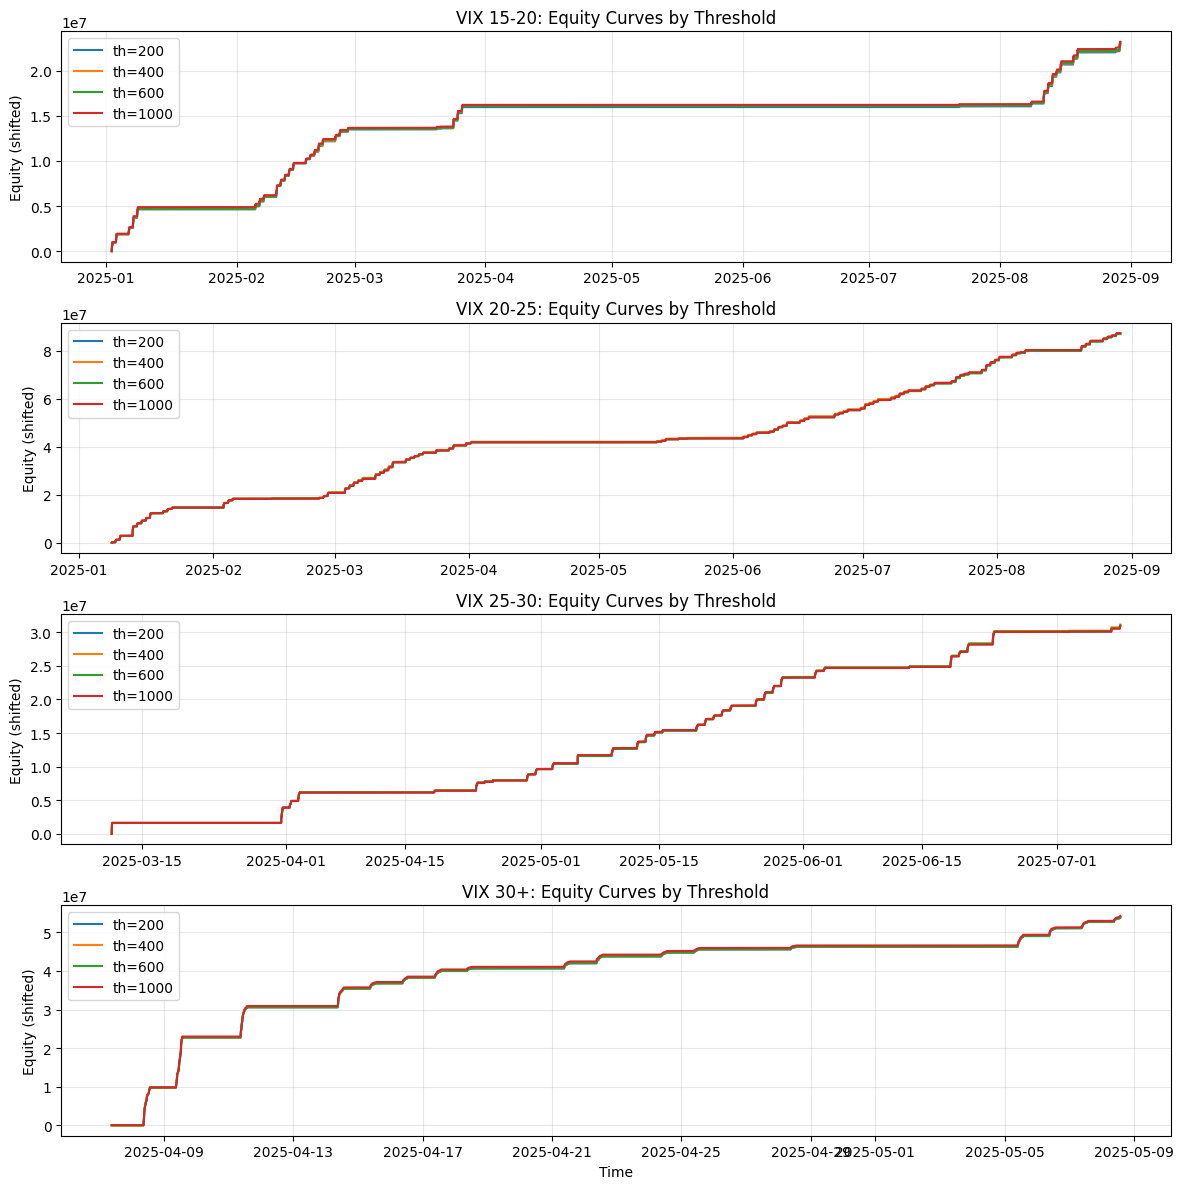

Per-bucket step PnL smoothness (lower std = smoother):
                  step_pnl_std  step_pnl_mean
bucket threshold                             
15-20  200.0      10323.454053    2636.952917
       400.0      10391.008767    2654.547371
       600.0      10468.599079    2656.000867
       1000.0     10659.598778    2681.112363
20-25  200.0      11165.596110    3664.041011
       400.0      11285.933315    3670.868719
       600.0      11401.256279    3654.844394
       1000.0     11847.021818    3671.307234
25-30  200.0      15459.628337    4309.053941
       400.0      15511.893721    4328.590991
       600.0      15609.283159    4313.262199
       1000.0     15456.232417    4292.295982
30+    200.0      34231.962419   10581.917600
       400.0      34298.174351   10601.322432
       600.0      34223.858151   10596.070026
       1000.0     34965.082133   10662.840797


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Per-bucket: plot all thresholds and show smoothness stats
if not bucket_results:
    print("bucket_results is empty; run the bucket analysis cell first.")
else:
    bucket_keys = sorted(bucket_results.keys(), key=lambda x: x[0])
    n = len(bucket_keys)
    fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=False)
    if n == 1:
        axes = [axes]
    smooth_records = []
    for ax, (low, high) in zip(axes, bucket_keys):
        data = bucket_results[(low, high)]
        all_results_bucket = data["all_results"]
        label_bucket = f"{int(low)}-{int(high)}" if np.isfinite(high) else f"{int(low)}+"
        for th, res in sorted(all_results_bucket.items()):
            curve = res["equity_curve"].copy()
            curve = curve - curve.iloc[0]  # shift start to 0
            ax.plot(curve.index, curve.values, label=f"th={th:.0f}")
            step_pnl = curve.diff().dropna()
            smooth_records.append({
                "bucket": label_bucket,
                "threshold": th,
                "step_pnl_std": step_pnl.std(),
                "step_pnl_mean": step_pnl.mean(),
            })
        ax.set_title(f"VIX {label_bucket}: Equity Curves by Threshold")
        ax.set_ylabel("Equity (shifted)")
        ax.grid(True, alpha=0.3)
        ax.legend()
    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

    # Smoothness table per bucket/threshold
    smooth_df_bucket = pd.DataFrame(smooth_records).sort_values(["bucket", "threshold"]).set_index(["bucket", "threshold"])
    print("Per-bucket step PnL smoothness (lower std = smoother):")
    print(smooth_df_bucket[["step_pnl_std", "step_pnl_mean"]])

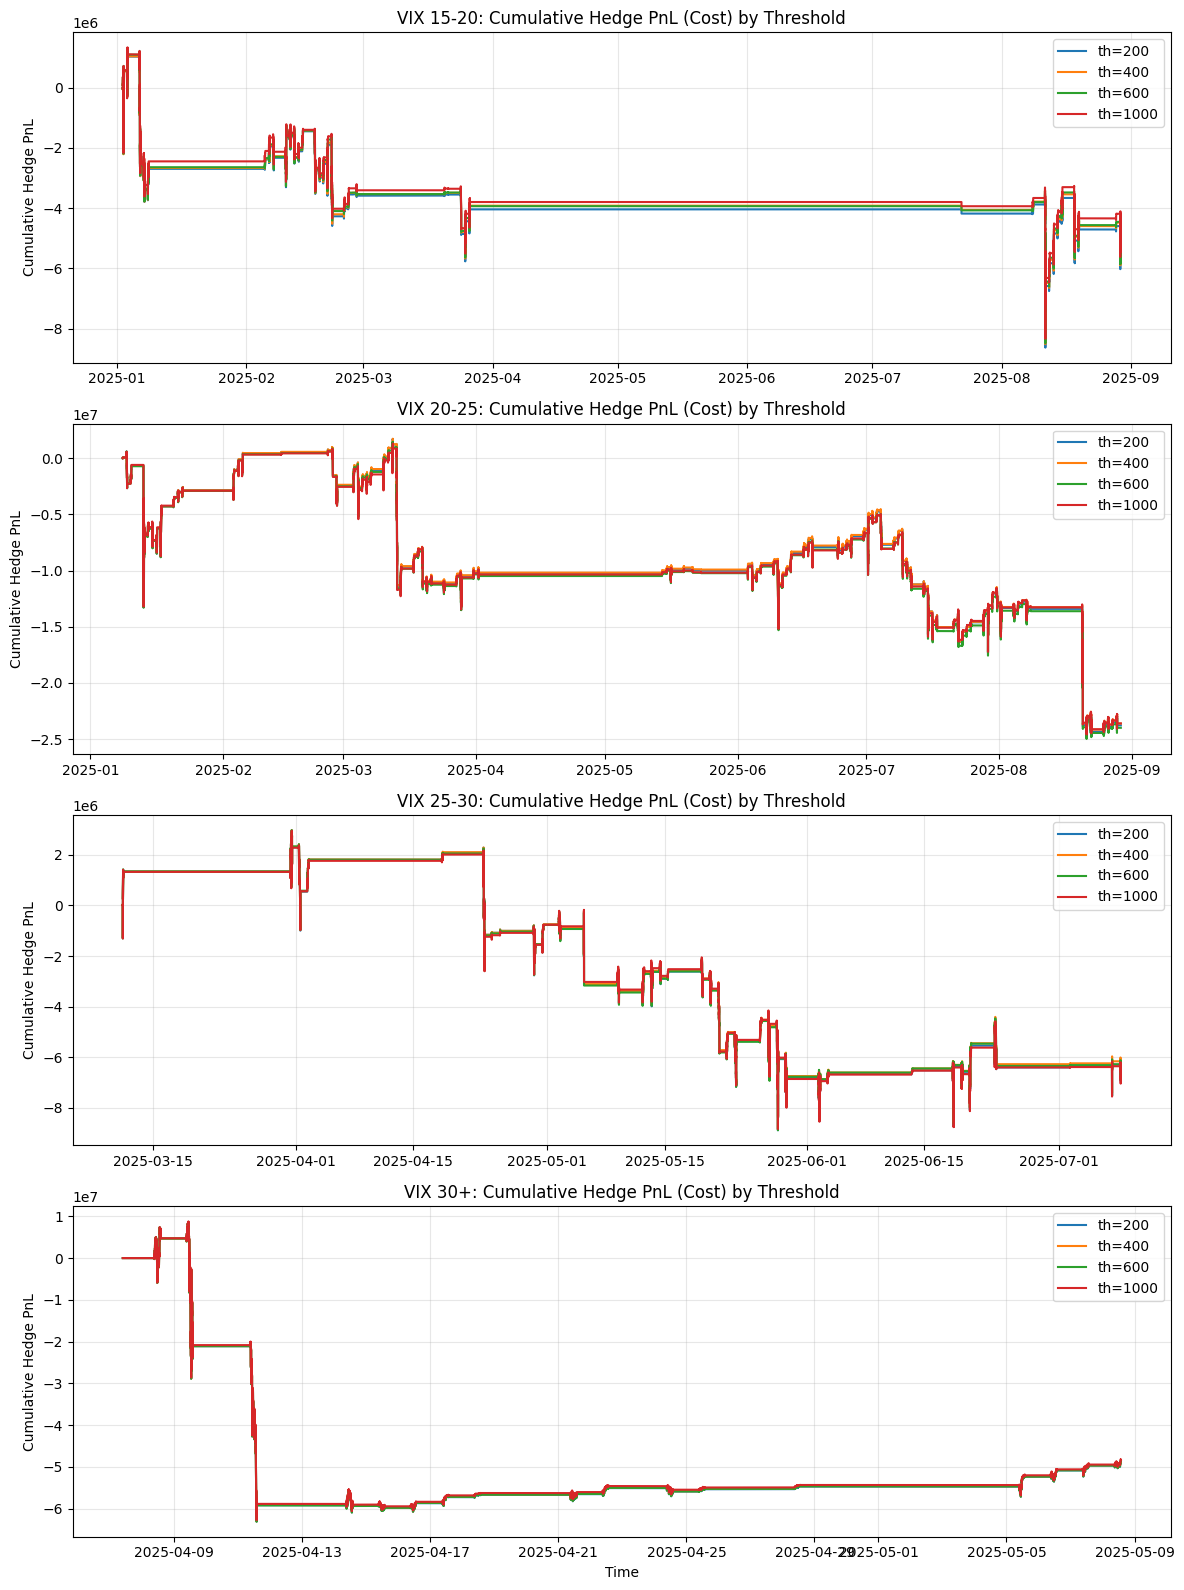

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Cumulative Hedge PnL Curves by VIX Bucket
# This shows the accumulation of hedge losses over time for each threshold in different volatility environments.

if 'bucket_results' in locals() and bucket_results:
    bucket_keys = sorted(bucket_results.keys(), key=lambda x: x[0])
    n = len(bucket_keys)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=False)
    if n == 1:
        axes = [axes]
    
    for ax, (low, high) in zip(axes, bucket_keys):
        data = bucket_results[(low, high)]
        all_results_bucket = data["all_results"]
        label_bucket = f"{int(low)}-{int(high)}" if np.isfinite(high) else f"{int(low)}+"
        
        for th, res in sorted(all_results_bucket.items()):
            # Extract cumulative hedge PnL
            if "details" in res and "hedge_pnl" in res["details"]:
                curve = res["details"]["hedge_pnl"].copy()
                if not curve.empty:
                    # Shift to start at 0 for clearer comparison of accumulation
                    curve = curve - curve.iloc[0]
                    ax.plot(curve.index, curve.values, label=f"th={th:.0f}")
        
        ax.set_title(f"VIX {label_bucket}: Cumulative Hedge PnL (Cost) by Threshold")
        ax.set_ylabel("Cumulative Hedge PnL")
        ax.grid(True, alpha=0.3)
        ax.legend()
        
    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()
else:
    print("bucket_results not found. Please run the VIX bucket analysis cell first.")

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df2.index,
    y=df2['mkt_mid'],
    mode='lines',
    name='mkt_mid'
))

fig.update_layout(
    title='TXF Market Mid Price',
    xaxis_title='Time',
    yaxis_title='Price',
    hovermode='x unified'
)
fig.show()